                 Price          MA  Volatility    Sharpe
Date                                                    
2025-09-29  254.429993  237.645332    0.254595  3.151572
2025-09-30  254.630005  238.436666    0.254016  3.284698
2025-10-01  255.449997  239.266332    0.253607  3.444005
2025-10-02  257.130005  240.303666    0.243898  4.487270
2025-10-03  258.019989  241.407666    0.242316  4.806807


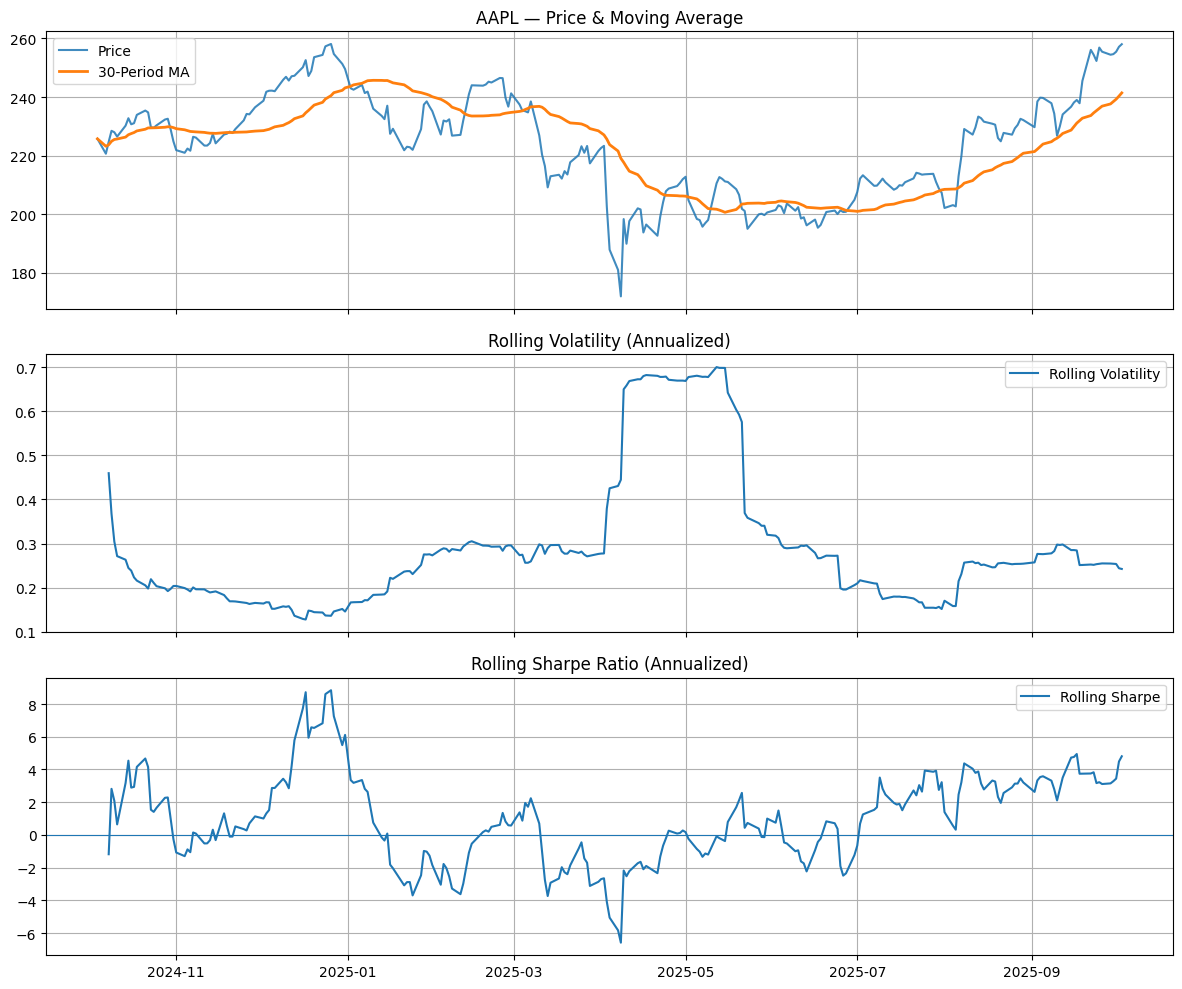

In [5]:
import math
import collections
from typing import Deque, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf


class RealTimeAnalytics:
    def __init__(self, window: int, periods_per_year: int = 252):
        if window < 2:
            raise ValueError("window must be >= 2")
        self.window = int(window)
        self.ppy = int(periods_per_year)

        self.prices: Deque[float] = collections.deque(maxlen=self.window)
        self.sum_prices = 0.0

        self.rets: Deque[float] = collections.deque(maxlen=self.window)
        self.sum_r = 0.0
        self.sumsq_r = 0.0

    def _push_return(self, r: float) -> None:
        if len(self.rets) == self.window:
            old = self.rets.popleft()
            self.sum_r -= old
            self.sumsq_r -= old * old
        self.rets.append(r)
        self.sum_r += r
        self.sumsq_r += r * r

    def update(self, price: Optional[float]) -> None:
        if price is None:
            return
        try:
            p = float(price)
        except (TypeError, ValueError):
            return
        if math.isnan(p):
            return

        if len(self.prices) == self.window:
            self.sum_prices -= self.prices[0]
        self.prices.append(p)
        self.sum_prices += p

        if len(self.prices) > 1:
            prev = self.prices[-2]
            if prev != 0 and not math.isnan(prev):
                r = (p / prev) - 1.0
                self._push_return(r)

    def mean_price(self) -> float:
        n = len(self.prices)
        return self.sum_prices / n if n > 0 else np.nan

    def _ret_stats(self):
        n = len(self.rets)
        if n < 2:
            return np.nan, np.nan
        mean_r = self.sum_r / n
        var_r = (self.sumsq_r - n * mean_r * mean_r) / (n - 1)
        if var_r < 0:
            var_r = 0.0
        std_r = math.sqrt(var_r)
        return mean_r, std_r

    def volatility(self) -> float:
        _, std_r = self._ret_stats()
        if np.isnan(std_r):
            return np.nan
        return std_r * math.sqrt(self.ppy)

    def sharpe(self, risk_free_annual: float = 0.02) -> float:
        mean_r, std_r = self._ret_stats()
        if np.isnan(mean_r) or np.isnan(std_r) or std_r == 0.0:
            return np.nan
        rf_per_period = risk_free_annual / self.ppy
        return (mean_r - rf_per_period) / std_r * math.sqrt(self.ppy)


def _extract_close_series(data: pd.DataFrame, ticker: str) -> pd.Series:
    """
    Normalize yfinance output to a 1-D float Series:
      - If Close is a DataFrame, pick the ticker column if present,
        otherwise take the first column.
      - Drop NaNs and cast to float.
    """
    close = data["Close"]
    if isinstance(close, pd.DataFrame):
        if ticker in close.columns:
            s = close[ticker]
        else:
            s = close.iloc[:, 0]
    else:
        s = close
    s = pd.to_numeric(s, errors="coerce").dropna()
    assert s.ndim == 1, "Close must be 1-D after extraction"
    return s.astype(float)


def process_stream(
    ticker: str = "AAPL",
    window: int = 20,
    period: str = "1y",
    interval: str = "1d",
    periods_per_year: int = 252,
    risk_free_annual: float = 0.02,
) -> pd.DataFrame:
    data = yf.download(
        ticker, period=period, interval=interval, auto_adjust=True, progress=False
    )
    if data.empty:
        raise SystemExit("No data returned—check ticker/period/interval.")

    prices = _extract_close_series(data, ticker)  # <-- ALWAYS a 1-D float Series

    stream = RealTimeAnalytics(window=window, periods_per_year=periods_per_year)
    ma, vol, shp = [], [], []

    # IMPORTANT: iterate over numeric values, not the Series object itself
    for p in prices.values:
        stream.update(p)
        ma.append(stream.mean_price())
        vol.append(stream.volatility())
        shp.append(stream.sharpe(risk_free_annual=risk_free_annual))

    df = pd.DataFrame(
        {"Price": prices.values, "MA": ma, "Volatility": vol, "Sharpe": shp},
        index=prices.index,
    )
    return df


def plot_indicators(df: pd.DataFrame, ticker: str, window: int) -> None:
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    axs[0].plot(df.index, df["Price"], label="Price", alpha=0.85)
    axs[0].plot(df.index, df["MA"], label=f"{window}-Period MA", linewidth=2)
    axs[0].set_title(f"{ticker} — Price & Moving Average"); axs[0].legend(); axs[0].grid(True)

    axs[1].plot(df.index, df["Volatility"], label="Rolling Volatility")
    axs[1].set_title("Rolling Volatility (Annualized)"); axs[1].legend(); axs[1].grid(True)

    axs[2].plot(df.index, df["Sharpe"], label="Rolling Sharpe")
    axs[2].axhline(0, linewidth=0.8)
    axs[2].set_title("Rolling Sharpe Ratio (Annualized)"); axs[2].legend(); axs[2].grid(True)

    plt.tight_layout(); plt.show()


if __name__ == "__main__":
    df = process_stream("AAPL", window=30, period="1y", interval="1d", periods_per_year=252)
    print(df.tail())
    plot_indicators(df, "AAPL", 30)
